In [283]:
from sklearn. model_selection import train_test_split
from sklearn. linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
import random

## Збір та попередня обробка даних

In [ ]:
# Хешуємо id для збереження конфіденційності даних

article = pd.read_excel('data/article.xlsx')
art_df['id'] = art_df.br_name + "_" + art_df.art_name
art_df =art_df.drop(['art_name', 'cat_name_uk', 'br_name', 'cat_name_uk', 'family_name', 'orig_name', 'orig_brand'], axis = 1)
art_df['hash_id'] = ''
for i in range (len(art_df.id)):
    art = art_df.id.iloc[i]
    hash_art = hashlib.md5(bytes(art, 'UTF-8'))
    hash_art_id = hash_art.hexdigest()
    art_df.art_id.iloc[i] = hash_art_id
art_df.to_excel('data/hash_table.xlsx')

In [284]:
# Завантажуємо дані для подальшого аналізу
art = pd.read_excel('data/hashed_article.xlsx')
cross = pd.read_excel('data/hashed_cross_bend.xlsx')
params = pd.read_excel('data/hashed_param_bend.xlsx')

In [285]:
cross.describe()

,id_1,id_2
count,9454,9454
unique,5186,2760
top,7bb80148ffb5e203abca7dd6ea2922ed,7bb80148ffb5e203abca7dd6ea2922ed
freq,21,77


In [286]:
params.describe()

,id,key_name,value
count,18095,18095,18095
unique,2793,21,907
top,a361dee9d597c0f8c327e4e84e21522a,відстань під вилку,CW
freq,10,1851,1513


In [287]:
art.describe()

,art_id
count,38604
unique,38604
top,d8d74e335b7e782a21a2facdec2acf0e
freq,1


In [242]:
# Зробимо зведену таблицю для оцінки наповненості параметрів
params_pivot = params.pivot_table(index='id', columns='key_name', values='value', aggfunc='first')
params_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2793 entries, 0018dfe581d55d345bfc3641ebeec5e5 to ffcb22a878c28da250270ac1820ac2dd
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   H.1                       1 non-null      object
 1   I.D.1                     8 non-null      object
 2   I.D.2                     1 non-null      object
 3   L.1                       6 non-null      object
 4   L.2                       1794 non-null   object
 5   O.D. 2                    2 non-null      object
 6   O.D1                      8 non-null      object
 7   Висота [mm]               1 non-null      object
 8   Зовнішній діаметр [mm]    3 non-null      object
 9   Кількість teeth/splines   8 non-null      object
 10  Напруга [V]               2 non-null      object
 11  Ширина [mm]               1 non-null      object
 12  відстань під вилку        1851 non-null   object
 13  діаметр втулки          

In [243]:
# Видалимо ті параметри, по яких майже нема даних
params_pivot = params_pivot.drop(['H.1', 'I.D.1', 'I.D.2', 'L.1', 
                                 'O.D. 2', 'O.D1', 'Висота [mm]',
                                 'Зовнішній діаметр [mm]', 
                                  'Кількість teeth/splines',
                                 'Напруга [V]', 'Ширина [mm]'], axis = 1)
params_pivot.describe()

key_name,L.2,відстань під вилку,діаметр втулки,діаметр обойми бендікса,діаметр шестерні,загальна довжина,кількість зубів,кількість шліців,обертання,початок шліцевої частини
count,1794,1851,1794,1794,1794,1794,1794,1794,1794,1851
unique,305,452,52,200,223,440,11,16,2,72
top,15,-,12,46,28,91,9,10,CW,0
freq,117,163,904,185,93,52,729,860,1513,1153


In [244]:
# Почистимо від нульових значень і лишніх символів
params_pivot = params_pivot.replace([0, '-', ''], None)
params_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2793 entries, 0018dfe581d55d345bfc3641ebeec5e5 to ffcb22a878c28da250270ac1820ac2dd
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   L.2                       1794 non-null   object
 1   відстань під вилку        1687 non-null   object
 2   діаметр втулки            1794 non-null   object
 3   діаметр обойми бендікса   1794 non-null   object
 4   діаметр шестерні          1794 non-null   object
 5   загальна довжина          1794 non-null   object
 6   кількість зубів           1794 non-null   object
 7   кількість шліців          1794 non-null   object
 8   обертання                 1794 non-null   object
 9   початок шліцевої частини  547 non-null    object
dtypes: object(10)
memory usage: 240.0+ KB


In [245]:
# Видалимо ще один параметр, даних по якому дуже мало
params_pivot = params_pivot.drop(['початок шліцевої частини'], axis = 1)
params_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2793 entries, 0018dfe581d55d345bfc3641ebeec5e5 to ffcb22a878c28da250270ac1820ac2dd
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   L.2                      1794 non-null   object
 1   відстань під вилку       1687 non-null   object
 2   діаметр втулки           1794 non-null   object
 3   діаметр обойми бендікса  1794 non-null   object
 4   діаметр шестерні         1794 non-null   object
 5   загальна довжина         1794 non-null   object
 6   кількість зубів          1794 non-null   object
 7   кількість шліців         1794 non-null   object
 8   обертання                1794 non-null   object
dtypes: object(9)
memory usage: 218.2+ KB


In [246]:
# Оцінимо парметри, по яких мало даних в розрізі рядків
def get_remaining_row_counts(df):
    remaining_row_counts = []

    for col in df.columns:
        df_temp = df.drop(col, axis=1)
        df_temp = df_temp.dropna()
        remaining_row_counts.append(len(df_temp))

    return remaining_row_counts
print(get_remaining_row_counts(params_pivot))

[838, 1794, 838, 838, 838, 838, 838, 838, 838]


In [247]:
# Видалимо параметр, який дуже урізає наш набір і по факту, його рідко використовують менеджери
params_pivot = params_pivot.drop(['відстань під вилку'], axis = 1)
params_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2793 entries, 0018dfe581d55d345bfc3641ebeec5e5 to ffcb22a878c28da250270ac1820ac2dd
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   L.2                      1794 non-null   object
 1   діаметр втулки           1794 non-null   object
 2   діаметр обойми бендікса  1794 non-null   object
 3   діаметр шестерні         1794 non-null   object
 4   загальна довжина         1794 non-null   object
 5   кількість зубів          1794 non-null   object
 6   кількість шліців         1794 non-null   object
 7   обертання                1794 non-null   object
dtypes: object(8)
memory usage: 196.4+ KB


In [248]:
# Почистимо набір від пустих значень
params_pivot.dropna(inplace=True)
params_pivot.describe()

key_name,L.2,діаметр втулки,діаметр обойми бендікса,діаметр шестерні,загальна довжина,кількість зубів,кількість шліців,обертання
count,1794,1794,1794,1794,1794,1794,1794,1794
unique,305,52,200,223,440,11,16,2
top,15,12,46,28,91,9,10,CW
freq,117,904,185,93,52,729,860,1513


In [249]:
params_pivot['обертання'].value_counts()

обертання
CW     1513
ACW     281
Name: count, dtype: int64

In [250]:
# Замінимо категоріальні значення цифровими
mapping = {"CW": 0, "ACW": 1}
params_pivot['обертання'] = params_pivot['обертання'].replace(mapping)

## Дослідження даних

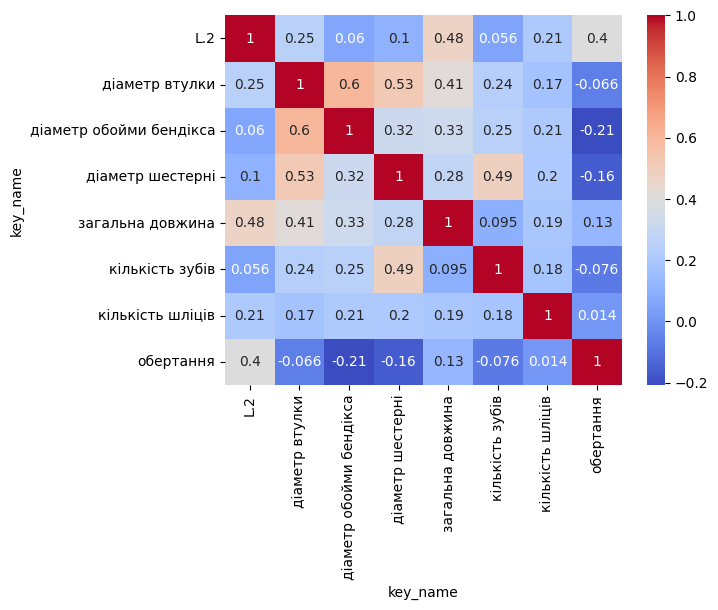

In [251]:
# Поглянемо чи є фактори, які мають сильну кореляцію
corr_matrix = params_pivot.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [252]:
# Зробимо проміжну таблицю кросів з параметрами
def cross_param_merge(cross, params_pivot):    
    merged_df = pd.merge(cross, params_pivot, left_on='id_1', right_on='id', how='left')
    merged_df = pd.merge(merged_df, params_pivot, left_on='id_2', right_on='id', how='left')
    return merged_df
merged_df = cross_param_merge(cross, params_pivot)
merged_df

,id_1,id_2,L.2_x,діаметр втулки_x,діаметр обойми бендікса_x,діаметр шестерні_x,загальна довжина_x,кількість зубів_x,кількість шліців_x,обертання_x,L.2_y,діаметр втулки_y,діаметр обойми бендікса_y,діаметр шестерні_y,загальна довжина_y,кількість зубів_y,кількість шліців_y,обертання_y
0,8478eb5ca1ebd617bfcae6504dc0304c,7710881d1e95876831e7a168dc74c362,22.7,14.5,59.1,40,91,10,10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7710881d1e95876831e7a168dc74c362,8478eb5ca1ebd617bfcae6504dc0304c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.7,14.5,59.1,40,91,10,10,0.0
2,8478eb5ca1ebd617bfcae6504dc0304c,14d690d98c227bb8c6a8d918a4c66932,22.7,14.5,59.1,40,91,10,10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14d690d98c227bb8c6a8d918a4c66932,8478eb5ca1ebd617bfcae6504dc0304c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.7,14.5,59.1,40,91,10,10,0.0
4,f366a835783e1dda2f187b9d2ea8e051,814de94cd342d6ed56a4b45e43f8ba54,15.4,12,48,30,58.3,9,10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9449,3169b975e5dd60feb86d58c620e7e53f,d70dc1339c475d9ba92dc828f09702f8,22.4,14,60,34.3,83,9,10,0.0,20.3,14.2,62,34.2,82,9,10,0.0
9450,6e22c25fb3a7f5dca40e10520122d156,cb2db45f1328a7a65e1b28ccbfd4a055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,12,54,32.6,69.5,10,10,0.0
9451,adc2fe0cc0f267926718a1d9578afd00,ecfbdd948e6513a535c7473f47254329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,17,68,40.4,87,11,16,0.0
9452,16ac235c37f3675260127cbdc63e8355,e117c16b812484a7c9ffc83d5a0ce8e1,45.2,13,53.4,29.6,85.6,9,14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [253]:
# Видалимо кроси, в деталях яких нема параметрів
merged_df.dropna(inplace = True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402 entries, 34 to 9449
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_1                       402 non-null    object 
 1   id_2                       402 non-null    object 
 2   L.2_x                      402 non-null    object 
 3   діаметр втулки_x           402 non-null    object 
 4   діаметр обойми бендікса_x  402 non-null    object 
 5   діаметр шестерні_x         402 non-null    object 
 6   загальна довжина_x         402 non-null    object 
 7   кількість зубів_x          402 non-null    object 
 8   кількість шліців_x         402 non-null    object 
 9   обертання_x                402 non-null    float64
 10  L.2_y                      402 non-null    object 
 11  діаметр втулки_y           402 non-null    object 
 12  діаметр обойми бендікса_y  402 non-null    object 
 13  діаметр шестерні_y         402 non-null    object 
 1

In [254]:
# Зробимо різницю в параметрах головними факторами для моделі
def cross_params_dif(merged_df):
    merged_df['L.2'] = np.abs(merged_df['L.2_x'] - merged_df['L.2_y'])
    merged_df['діаметр втулки'] = np.abs(merged_df['діаметр втулки_x'] - merged_df['діаметр втулки_y'])
    merged_df['діаметр обойми бендікса'] = np.abs(merged_df['діаметр обойми бендікса_x'] - merged_df['діаметр обойми бендікса_y'])
    merged_df['діаметр шестерні'] = np.abs(merged_df['діаметр шестерні_x'] - merged_df['діаметр шестерні_y'])
    merged_df['загальна довжина'] = np.abs(merged_df['загальна довжина_x'] - merged_df['загальна довжина_y'])
    merged_df['кількість зубів'] = np.abs(merged_df['кількість зубів_x'] - merged_df['кількість зубів_y'])
    merged_df['кількість шліців'] = np.abs(merged_df['кількість шліців_x'] - merged_df['кількість шліців_y'])
    merged_df['обертання'] = np.abs(merged_df['обертання_x'] - merged_df['обертання_y'])
    # Видалення зайвих стовпців
    columns_to_keep = ['id_1', 'id_2', 'L.2', 'діаметр втулки', 'діаметр обойми бендікса', 'діаметр шестерні',
                      'загальна довжина', 'кількість зубів', 'кількість шліців', 'обертання']
    data = merged_df[columns_to_keep]
    return data
data = cross_params_dif(merged_df)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402 entries, 34 to 9449
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_1                     402 non-null    object 
 1   id_2                     402 non-null    object 
 2   L.2                      402 non-null    object 
 3   діаметр втулки           402 non-null    object 
 4   діаметр обойми бендікса  402 non-null    object 
 5   діаметр шестерні         402 non-null    object 
 6   загальна довжина         402 non-null    object 
 7   кількість зубів          402 non-null    object 
 8   кількість шліців         402 non-null    object 
 9   обертання                402 non-null    float64
dtypes: float64(1), object(9)
memory usage: 34.5+ KB


In [255]:
# Додамо результат, який будемо передбачувати
data['result'] = True

C:\Users\user\AppData\Local\Temp\ipykernel_10144\789680713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['result'] = True


In [256]:
# Згенеруємо хибні кроси для навчання моделі
data = data.reset_index(drop=True)
existing_pairs = set()
for _, row in data.iterrows():
    pair = (row['id_1'], row['id_2'])
    reversed_pair = (row['id_2'], row['id_1'])
    existing_pairs.add(pair)
    existing_pairs.add(reversed_pair)
new_rows = []
num_new_rows = len(data) #кількість нових хибних кросів, які ми хочемо згенерувати
while len(new_rows) < num_new_rows:
    id_1 = random.choice(data['id_1'])
    id_2 = random.choice(data['id_2'])
    pair = (id_1, id_2)
    reversed_pair = (id_2, id_1)
    if pair not in existing_pairs and id_1 != id_2 and reversed_pair not in existing_pairs:
        new_rows.append({'id_1': id_1, 'id_2': id_2})
        existing_pairs.add(pair)
        existing_pairs.add(reversed_pair)

wrong_data = pd.DataFrame(new_rows)
wrong_data

,id_1,id_2
0,a830531390a7fc6bab926708be40f370,e783f978f62ea75174a276d84d582f8d
1,6288ba40e61d0e333f823a64c065793e,0c0f46679dd80b8c4ba894f2d14bc026
2,4efa974c2772fc51d23e0d5d0ce01174,23ebe0812a3915ed94ec8350c6f86d28
3,750c7b9fef0935b7ae6cb4a5e469b7a6,64706c218f3a28fe9c7c1018bc390c91
4,7357f5ab662989db492fbc7e9a6b3cb7,8f9d5eaaf1f630ddf59fff4bb69e5bba
...,...,...
397,148a92d51c07dc28589cc1aac190074a,e604876a52db9b0afdb95f2a191a97c1
398,6ec70530402dafba4951b5de3ccb5a25,3e3820235e5bcd09011bc3ea52eb43a2
399,99a06c51a4fe5fd77dc66f0eb6af3b45,63dba597f40c1d03bf37f6d24918934c
400,77b2db014c2d02052b96f5c8beae834d,ccb05b46da694d0dee50b2d6cfa2fe0f


In [257]:
merged_wrong_data = cross_param_merge(wrong_data, params_pivot)
wrong_data = cross_params_dif(merged_wrong_data)
wrong_data['result'] = False
wrong_data

C:\Users\user\AppData\Local\Temp\ipykernel_10144\505215578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_data['result'] = False


,id_1,id_2,L.2,діаметр втулки,діаметр обойми бендікса,діаметр шестерні,загальна довжина,кількість зубів,кількість шліців,обертання,result
0,a830531390a7fc6bab926708be40f370,e783f978f62ea75174a276d84d582f8d,31,6,14.3,7.5,57.4,0,2,0,False
1,6288ba40e61d0e333f823a64c065793e,0c0f46679dd80b8c4ba894f2d14bc026,3.3,1,6.1,0.1,20.8,0,5,0,False
2,4efa974c2772fc51d23e0d5d0ce01174,23ebe0812a3915ed94ec8350c6f86d28,6.2,2.3,12.3,11.4,31.2,2,0,0,False
3,750c7b9fef0935b7ae6cb4a5e469b7a6,64706c218f3a28fe9c7c1018bc390c91,0.8,1.7,1.4,6.1,12.5,2,2,0,False
4,7357f5ab662989db492fbc7e9a6b3cb7,8f9d5eaaf1f630ddf59fff4bb69e5bba,7.4,2.3,15.6,11.6,31.7,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...
397,148a92d51c07dc28589cc1aac190074a,e604876a52db9b0afdb95f2a191a97c1,6.3,2,8.2,11.7,31.2,1,4,0,False
398,6ec70530402dafba4951b5de3ccb5a25,3e3820235e5bcd09011bc3ea52eb43a2,32.0,2.3,10.4,6.1,8.2,0,2,0,False
399,99a06c51a4fe5fd77dc66f0eb6af3b45,63dba597f40c1d03bf37f6d24918934c,20.5,1,6.1,2.6,20.5,1,0,1,False
400,77b2db014c2d02052b96f5c8beae834d,ccb05b46da694d0dee50b2d6cfa2fe0f,8.1,2,7,14.4,23,1,2,0,False


In [258]:
data = pd.concat([data, wrong_data], ignore_index=True)
data

,id_1,id_2,L.2,діаметр втулки,діаметр обойми бендікса,діаметр шестерні,загальна довжина,кількість зубів,кількість шліців,обертання,result
0,bf394e189e1d06ef371caabbdbae574a,8f9d5eaaf1f630ddf59fff4bb69e5bba,1.2,0,1.2,0,0.0,0,0,0.0,True
1,8f9d5eaaf1f630ddf59fff4bb69e5bba,bf394e189e1d06ef371caabbdbae574a,1.2,0,1.2,0,0.0,0,0,0.0,True
2,7aae25debfb9a69a3a1938195507e631,42e7fce2b9b3afa35d063848474d2878,1,0,0,1,0.2,0,6,0.0,True
3,1d7500443fa9960e068f04670deee69c,3da2073e8dea3d2daf741536853016aa,0.7,0,3,0.3,1.9,0,0,0.0,True
4,148a92d51c07dc28589cc1aac190074a,d02c40e2c1a7cd2076743c65aa359698,3.7,0,1.0,0.0,1,0,0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
799,148a92d51c07dc28589cc1aac190074a,e604876a52db9b0afdb95f2a191a97c1,6.3,2,8.2,11.7,31.2,1,4,0.0,False
800,6ec70530402dafba4951b5de3ccb5a25,3e3820235e5bcd09011bc3ea52eb43a2,32.0,2.3,10.4,6.1,8.2,0,2,0.0,False
801,99a06c51a4fe5fd77dc66f0eb6af3b45,63dba597f40c1d03bf37f6d24918934c,20.5,1,6.1,2.6,20.5,1,0,1.0,False
802,77b2db014c2d02052b96f5c8beae834d,ccb05b46da694d0dee50b2d6cfa2fe0f,8.1,2,7,14.4,23,1,2,0.0,False


In [259]:
data['result'].value_counts()

result
True     402
False    402
Name: count, dtype: int64

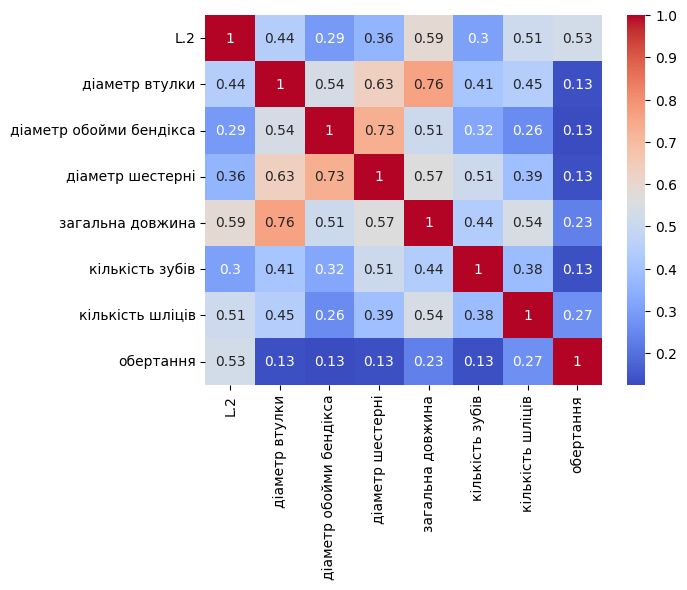

In [260]:
cor = data.drop(['result', 'id_1', 'id_2'], axis=1)
corr_matrix = cor.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Побудова моделі машинного навчання

In [274]:
X = data.drop(['result', 'id_1', 'id_2'], axis=1)
y = data['result']

# ділимо дані на тренувальні та тестові
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=data['result'], random_state=42)

In [275]:
# створюємо та навчаємо модель логістичної регресії
model_log_reg = LogisticRegression()
model_log_reg.fit(X_train, y_train)

# передбачаємо класи для тестових даних
y_pred = model_log_reg.predict(X_test)

# обчислюємо точність моделі
accuracy_log_reg = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9813664596273292


## Інтерпретація результатів та візуалізація

<Axes: >

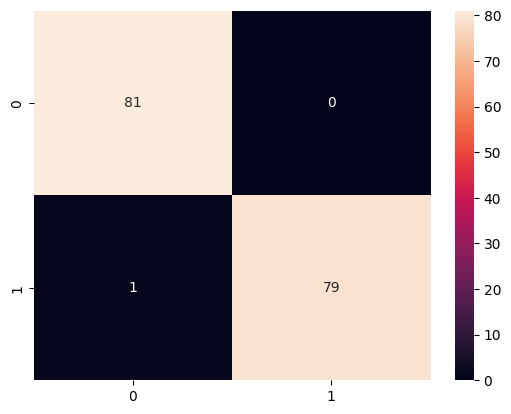

In [276]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax)

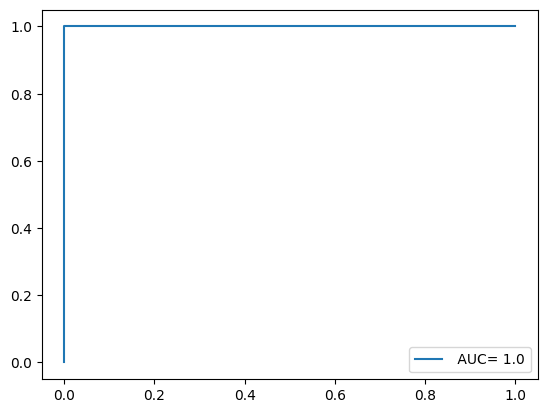

In [269]:
y_pred_proba = model_log_reg.predict_proba (X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve (y_test, y_pred_proba)
auc = metrics.roc_auc_score (y_test, y_pred_proba)
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.legend(loc=4)
plt.show()

### Модель показує занадто добрий результат, спробуємо ще якісь варіанти

In [270]:
# Використуємо DecisionTreeClassifier 
model_des_tree = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=3, min_samples_leaf=5)
model_des_tree.fit(X_train, y_train)
y_pred = model_des_tree.predict(X_test)
accuracy_model_des_tree = metrics.accuracy_score(y_test, y_pred)
print(accuracy_model_des_tree)

0.9813664596273292


In [282]:
# Використаємо ансамбль моделей LogisticRegression і SGDClassifier
estimators = [('lgr', LogisticRegression()), ('sgc', SGDClassifier())]
model_stacking_clas = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier())
model_stacking_clas.fit(X_train, y_train)
accuracy_model_stacking_clas = model_stacking_clas.score(X_test, y_test)
print(accuracy_model_stacking_clas)

0.9627329192546584


In [272]:
# Використаємо Bagging з базовим оцінювачем LogisticRegression (ансамбль моделей)
model_bagging_clas = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=20, random_state=12)
model_bagging_clas.fit(X_train, y_train)
accuracy_model_bagging_clas = model_bagging_clas.score(X_test, y_test)
print(accuracy_model_bagging_clas)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9937888198757764


In [281]:
# Метод опорних векторів з лінійним ядром
model_svc_lin = svm.SVC(kernel='linear')
model_svc_lin.fit(X_train, y_train)
y_pred = model_svc_lin.predict(X_test)
accuracy_model_svc_lin = metrics.accuracy_score(y_test, y_pred)
print(accuracy_model_svc_lin)

1.0
